In [2]:
from path import Path
from fastai.vision import *
import numpy as np
import pandas as pd
from PIL import Image

In [3]:
path = Path('/home/jupyter/kaggle/iwildcam/data')

In [4]:
path.ls()

[PosixPath('/home/jupyter/kaggle/iwildcam/data/submission.csv'),
 PosixPath('/home/jupyter/kaggle/iwildcam/data/sample_submission.csv'),
 PosixPath('/home/jupyter/kaggle/iwildcam/data/data.sh')]

In [8]:
##Reformat training  and test csv
df_train_raw = pd.read_csv(path/'train/train_raw.csv')
df_test_raw = pd.read_csv(path/'test/test_raw.csv')

In [9]:
def reformat(df_raw, dataset):
    """Reformats raw data into suitable df for databunch
    """
    if dataset == 'train':
        df_format = pd.DataFrame(columns=['image_name', 'category'])
        df_format['image_name'] = df_raw['file_name']
        df_format['category'] = df_raw['category_id']
    elif dataset == 'test':
        df_format = pd.DataFrame(columns=['image_name'])
        df_format['image_name'] = df_raw['file_name']
    df_format.to_csv(path/'{0}/{0}.csv'.format(dataset), index=False)

In [10]:
reformat(df_train_raw, 'train')
reformat(df_test_raw, 'test')

In [6]:
#read full training data
df_train = pd.read_csv(path/'train/train.csv')

In [7]:
#create a random sample of a subset of training data for initial model testing
df_train.sample(5000).to_csv(path/'train/train.sample.csv', index=False)

In [8]:
#create dadtabunch with batch size 16, create val set by random percent
bs = 16
np.random.seed(42)
tfms = get_transforms(do_flip=True,
                      max_lighting=.6,
                      )
df = pd.read_csv(path/'train'/'train.full.csv')
data = (ImageList.from_df(df=df, path=path/'train')
       .split_by_rand_pct(.1)
       .label_from_df()
       .add_test_folder(path/'test')
       .transform(tfms, size=224)
       .databunch(bs=bs))

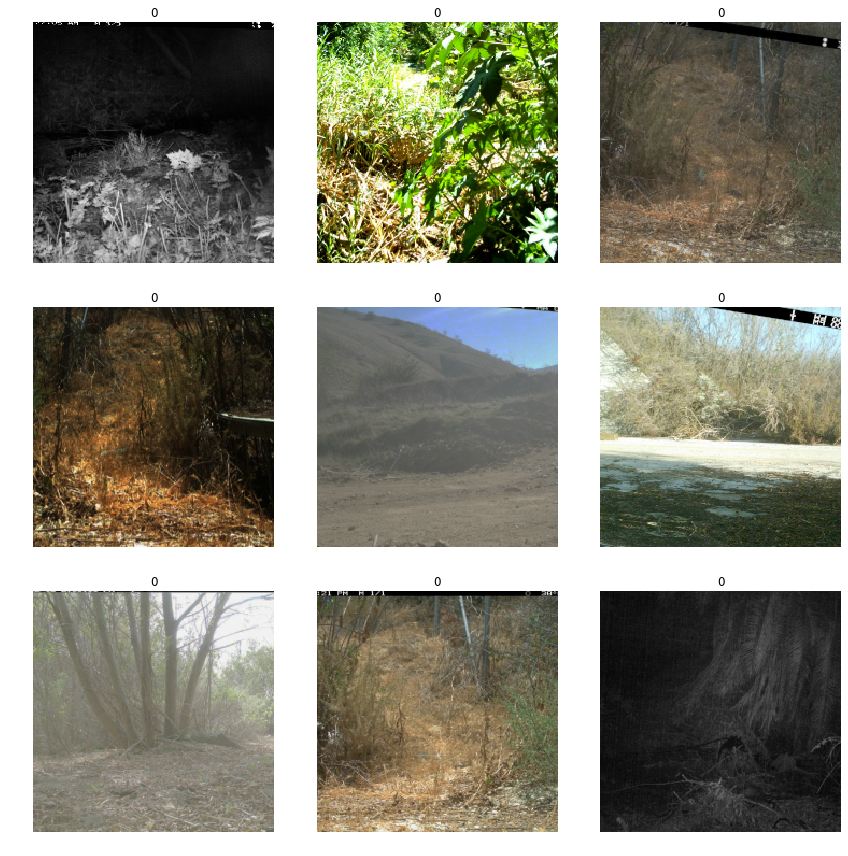

In [9]:
data.show_batch(rows=3)

In [10]:
#define custom F1 metric 
import sklearn.metrics
@dataclass
class F1(Callback):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        
    def on_epoch_begin(self, **kwargs):
        self.y_pred = torch.tensor([]).cuda()
        self.y_true = torch.tensor([]).cuda()

    def on_batch_end(self, last_output, last_target, **kwargs):
        pred_class = self.classes[last_output.argmax(dim=1)].cuda()
        self.y_pred = torch.cat((self.y_pred, pred_class.float()))
        self.y_true = torch.cat((self.y_true, last_target.float()))
        pass

    def on_epoch_end(self, last_metrics, **kwargs):
        f1 = sklearn.metrics.f1_score(self.y_true, self.y_pred, average='macro')
        return add_metrics(last_metrics, f1)


In [11]:
learn = cnn_learner(data, models.resnet34, metrics=[F1(torch.Tensor(data.classes)), accuracy])

In [12]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,f1,accuracy,time
0,0.518198,0.398612,0.101220,0.871262,35:45


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [13]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

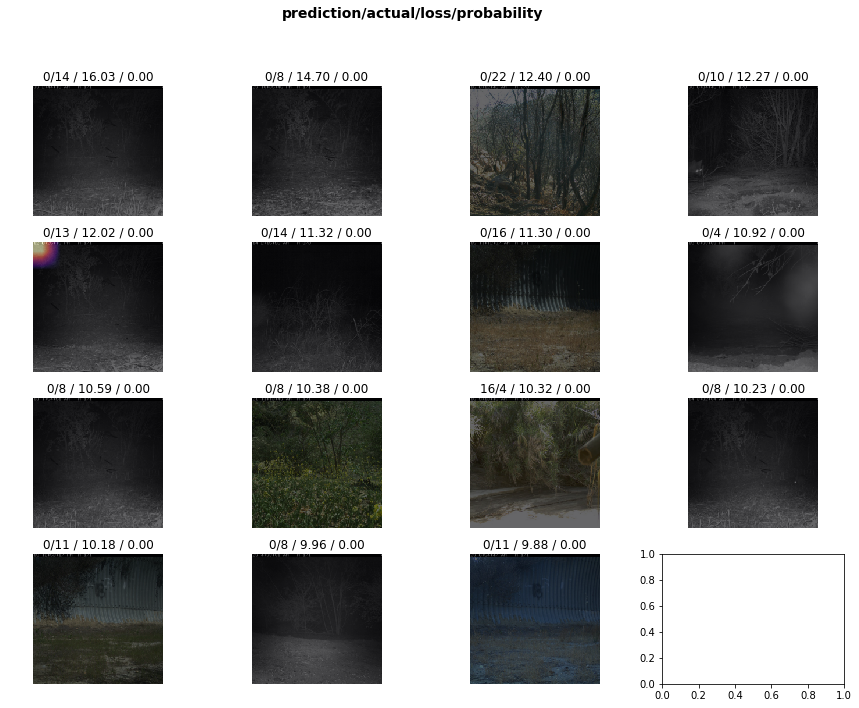

In [14]:
interp.plot_top_losses(15, figsize=(15,11))

In [15]:
learn.save('stage-1')

In [21]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (176670 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
19,19,0,0,3
Path: /home/jupyter/kaggle/iwildcam/data/train;

Valid: LabelList (19629 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,19,0
Path: /home/jupyter/kaggle/iwildcam/data/train;

Test: LabelList (153730 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/kaggle/iwildcam/data/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=F

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


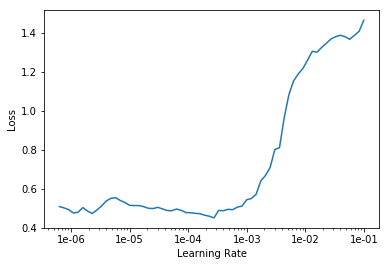

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1, slice(5e-5, 7e-3))

epoch,train_loss,valid_loss,f1,accuracy,time
0,0.375003,0.406430,0.097241,0.896480,31:09


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [60]:
learn.freeze()

In [61]:
learn.fit_one_cycle(3, slice(1e-5, 1e-4), wd=.01)

epoch,train_loss,valid_loss,f1,accuracy,time
0,0.832589,0.781459,0.094586,0.771000,00:47
1,0.836007,0.759129,0.093392,0.777000,00:47
2,0.847314,0.764277,0.094107,0.773000,00:46


In [22]:
#get test set predictions and format for submission
preds, y = learn.get_preds(ds_type=DatasetType.Test)

In [23]:
pred_classes = torch.Tensor(data.classes)[preds.argmax(dim=1)]

In [24]:
df_test = pd.read_csv(path/'test/test_raw.csv')

In [25]:
df_result = df_test[['id']].rename(columns={'id':'Id'})

In [26]:
df_result['Predicted'] = pred_classes
df_result['Predicted'] = df_result['Predicted'].astype(int)

In [27]:
df_result.to_csv(path/'submission.csv', index=False)

In [28]:
df_result.head()

,Id,Predicted
0,bce932f6-2bf6-11e9-bcad-06f10d5896c4,1
1,bce932f7-2bf6-11e9-bcad-06f10d5896c4,0
2,bce932f8-2bf6-11e9-bcad-06f10d5896c4,18
3,bce932f9-2bf6-11e9-bcad-06f10d5896c4,0
4,bce932fa-2bf6-11e9-bcad-06f10d5896c4,0
